In [5]:
import json
api_token = {"username":"iobananaoi","key":"0cbdda23beeb18cbb57e9e88bf26bfd1"}


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [155]:
import os
import gc
import kaggle 
import torch 
import cv2
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from datetime import date
from torch import nn
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader
from os import listdir
from os.path import isfile, join
from torchvision.transforms import ToTensor, Compose, ToPILImage, CenterCrop
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.optim import lr_scheduler
from PIL import Image

In [7]:
!kaggle datasets download -d faizalkarim/flood-area-segmentation

 99% 106M/107M [00:03<00:00, 39.2MB/s]
100% 107M/107M [00:03<00:00, 31.0MB/s]


In [8]:
f = ZipFile("/content/flood-area-segmentation.zip")
f.extractall("/content/data")

In [9]:
def img_rename(src, dim) -> None:
    files = [f for f in listdir(src) if isfile(join(src, f))]
    for i, name in enumerate(files):  

        name = src+name
        new_name = src + f"{i}.{dim}"
        print(new_name)

        os.rename(name, new_name)

In [102]:
batch_size = 32
epochs = 15
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [55]:
meta = pd.read_csv("/content/data/metadata.csv")
meta.drop(index=[0,2])

,Image,Mask
1,1.jpg,1.png
3,3.jpg,3.png
4,4.jpg,4.png
5,5.jpg,5.png
6,6.jpg,6.png
...,...,...
285,1083.jpg,1083.png
286,1084.jpg,1084.png
287,1085.jpg,1085.png
288,1086.jpg,1086.png


# Data processing

In [90]:
class DS(Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.meta = pd.read_csv("/content/data/metadata.csv")
        self.meta.drop(index=[0,2, 151], inplace=True)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        img = Image.open("/content/data/Image/"+self.meta.iloc[idx]["Image"])
        label = Image.open("/content/data/Mask/"+self.meta.iloc[idx]["Mask"])
        
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
        
        return img, label

In [91]:
ds = DS(Compose([CenterCrop(304), ToTensor()]))

In [93]:
dl = DataLoader(ds, batch_size, shuffle=True)

In [94]:
batch_num = len(ds) // batch_size

# Model structure

### Consider various model structures such as U-Net and DEEPLABV3 and then compare the results

In [104]:
u_net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


# Training

In [105]:
def train(model, dataloader, loss_fn, optim, scheduler, epochs=epochs):
    model.train()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000
    losses = []

    for epoch in range(epochs):
        print(f"======= Epoch {epoch+1} =======")
        running_loss = 0.0

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            if batch < batch_num:
                optim.zero_grad()
                pred = model(X)
                loss = loss_fn(pred, y)

                loss.backward()
                optim.step()

                running_loss += loss.item()
        running_loss /= batch_num
        losses.append(running_loss)
        print(f"Loss: {running_loss:.4f}")

        if running_loss < best_loss:
            best_loss = running_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
    model.load_state_dict(best_model_wts)   

    print(f"Model state saved with the best loss: {best_loss:.4f}")

    return losses     

## U_net

In [106]:
model = u_net.to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
loss_fn = nn.BCELoss()

In [107]:
gc.collect()
torch.cuda.empty_cache()

In [108]:
losses = train(model, dl, loss_fn, optim, scheduler, epochs)

======= Epoch 1 =======


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  warnings.warn(


Loss: 1.8741
======= Epoch 2 =======
Loss: 0.7805
======= Epoch 3 =======
Loss: 0.5822
======= Epoch 4 =======
Loss: 0.5596
======= Epoch 5 =======
Loss: 0.5081
======= Epoch 6 =======
Loss: 0.4753
======= Epoch 7 =======
Loss: 0.4502
======= Epoch 8 =======
Loss: 0.4475
======= Epoch 9 =======
Loss: 0.4308
======= Epoch 10 =======
Loss: 0.4194
======= Epoch 11 =======
Loss: 0.3919
======= Epoch 12 =======
Loss: 0.4134
======= Epoch 13 =======
Loss: 0.4053
======= Epoch 14 =======
Loss: 0.4134
======= Epoch 15 =======
Loss: 0.3788
Model state saved with the best loss: 0.0000


## Deeplabv3

In [119]:
deeplabv3 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [120]:
model = deeplabv3.to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
loss_fn = nn.BCELoss()

In [146]:
gc.collect()
torch.cuda.empty_cache()

In [147]:
img = to_tensor(Image.open("/content/data/Image/1000.jpg")).to(device)

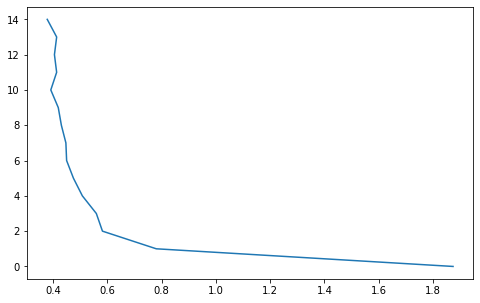

In [112]:
plt.figure(figsize=(8, 5))
plt.plot(losses, range(epochs))
plt.show()

# Results comparing